A short tutorial of how to use `KIM`.

# Consider a multivariate model
## Model Overview

Let the input vector be:  
**x** = [x₁, x₂, x₃, x₄]

Let the output vector be:  
**y** = [y₁, y₂, y₃]

The model is defined as:

- y₁ = sin(x₁) + log(1 + x₂²)  
- y₂ = exp(−x₃) + 0.5 · x₁²  
- y₃ = x₄ / (1 + x₂²) + tanh(x₃)

## Dependencies

- **y₁** depends on **x₁** and **x₂** only  
- **y₂** depends on **x₁** and **x₃** only  
- **y₃** depends on **x₂**, **x₃**, and **x₄**

Thus, not all inputs are important for all outputs — this creates a **sparse input-output dependency structure**.

In [1]:
import numpy as np
def multivariate_nonlinear_model(x):
    """
    Multivariate nonlinear model with 4 inputs and 3 outputs.
    
    Parameters:
        x : ndarray of shape (..., 4)
            Input array where each row corresponds to a 4-dimensional input.
    
    Returns:
        y : ndarray of shape (..., 3)
            Output array with 3 outputs per input row.
    """
    x = np.asarray(x)
    x1, x2, x3, x4 = x[..., 0], x[..., 1], x[..., 2], x[..., 3]

    y1 = np.sin(x1) + np.log(1 + x2**2)
    y2 = np.exp(-x3) + 0.5 * x1**2
    y3 = x4 / (1 + x2**2) + np.tanh(x3)

    y = np.stack([y1, y2, y3], axis=-1)
    return y


# Generate $N_s$ model inputs and outputs

In [2]:
Ns = 500  # Number of samples
Nx = 4  # Number of input variables
Ny = 3  # Number of output variables

# Inputs and outputs
x = np.random.randn(Ns, Nx)
y = multivariate_nonlinear_model(x)


Text(0.5, 1.02, 'Scatter plots of each $x_i$ vs $y_j$')

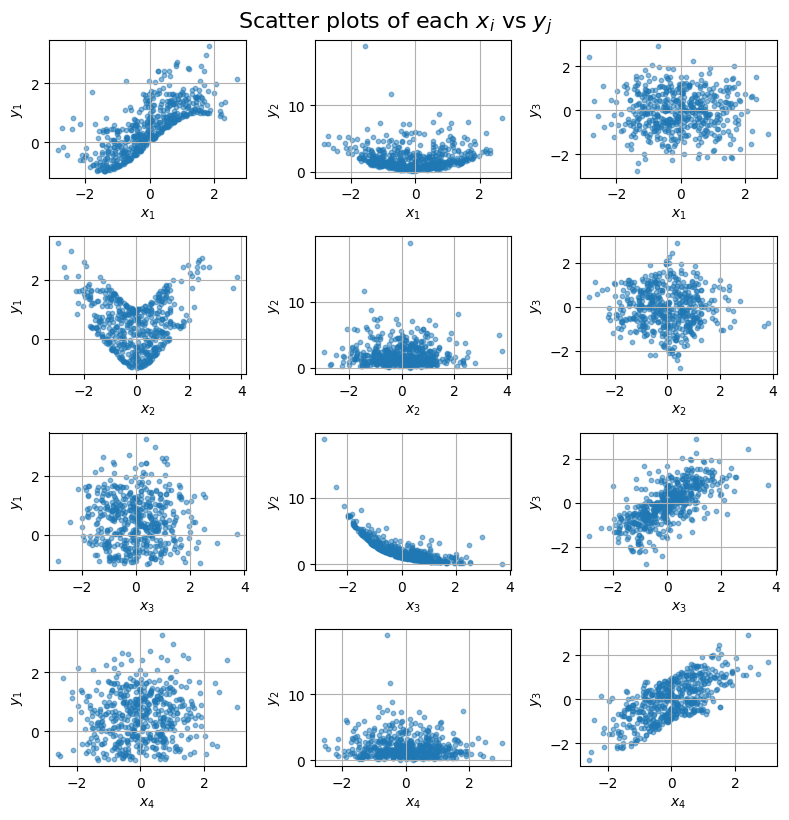

In [3]:
# Now, let's plot them
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 8))
for i in range(4):   # x1 to x4
    for j in range(3):  # y1 to y3
        ax = axes[i, j]
        ax.scatter(x[:, i], y[:, j], alpha=0.5, s=10)
        ax.set_xlabel(f"$x_{i+1}$")
        ax.set_ylabel(f"$y_{j+1}$")
        ax.grid(True)
plt.tight_layout()
plt.suptitle("Scatter plots of each $x_i$ vs $y_j$", fontsize=16, y=1.02)

# Perform the preliminary analysis

## Configuring the preliminary analysis


In [4]:
# Data configuration
data_params = {
    "xscaler_type": "minmax",  # scaler for the x (input) data
    "yscaler_type": "minmax",  # scaler for the y (output) data
}

# Preliminary analysis configuration
sensitivity_params = {
    "method": "pc", "metric": "it-knn",
    "sst": True, "ntest": 100, "alpha": 0.05, "k": 3,
    "n_jobs": 4, "seed_shuffle": 1234,
    "verbose": 1
}


## Run the preliminary analysis

In [5]:
from kim import Data
data = Data(x, y, **data_params)
data.calculate_sensitivity(**sensitivity_params)

Using the kNN-based information theoretic metrics ...
Performing pairwise analysis to remove insensitive inputs ...


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Performing conditional independence testing to remove redundant inputs ...


## Save the results

In [ ]:
from pathlib import Path
f_data_save = Path('./data')
data.save(f_data_save)


# Perform the ensemble learning

## Configure the ensemble learning

In [8]:
from kim.map import KIM
from kim.mapping_model import MLP

# Mapping parameters for each test below
map_configs = {
    "model_type": MLP,
    'n_model': 100,
    'ensemble_type': 'ens_random',
    'model_hp_choices': {
        "depth": [1,3,5,6],
        "width_size": [3,6,10]
    },
    'model_hp_fixed': {
        "hidden_activation": 'sigmoid',
        "final_activation": 'leaky_relu',
        "model_seed": 100
    },
    'optax_hp_choices': {
        'learning_rate': [0.01, 0.005, 0.003],
    },
    'optax_hp_fixed': {
        'nsteps': 300,
        'optimizer_type': 'adam',
    },
    'dl_hp_choices': {
    },
    'dl_hp_fixed': {
        'dl_seed': 10,
        'num_train_sample': 400,
        'num_val_sample': 50,
        'batch_size': 64
    },
    'ens_seed': 1024,
    'training_parallel': True,
    'parallel_config': {
        'n_jobs': 4, 
        'backend': 'loky',
        'verbose': 1
    },
    'device': None,
}

## Train the ensemble neural network

In [10]:
kim_map = KIM(data, map_configs, mask_option="cond_sensitivity", map_option='many2one')
kim_map.train()


 Performing ensemble training in parallel with 100 model configurations...



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
 84%|████████▍ | 252/300 [00:01<00:00, 238.93it/s]/Users/peishi/miniforge3/envs/kim/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 300/300 [00:01<00:00, 175.25it/s]
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   52.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
  0%|          | 0/300 [00:00<?, ?it/s]

Training completes.

 Performing ensemble training in parallel with 100 model configurations...



100%|██████████| 300/300 [00:01<00:00, 220.73it/s]
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   49.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Training completes.

 Performing ensemble training in parallel with 100 model configurations...



100%|██████████| 300/300 [00:01<00:00, 155.47it/s]
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.0s
100%|██████████| 300/300 [00:01<00:00, 162.91it/s]


Training completes.


100%|██████████| 300/300 [00:01<00:00, 211.73it/s]
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   57.1s finished


## Save the training results

In [ ]:
f_kim = Path('./kim')
kim_map.save(f_kim)
